# 18.337/6.338, Numerical computing with Julia
# 2015/09/14

- Julia Installfest by Prof. Steven G. Johnson, this afternoon, 5-7pm in 32-155.
  - 5-5:45 short overview and tutorial
  - 5:45-7 open-ended Q&A, installation help.

- The course GitHub repository is at <https://github.com/alanedelman/18.337_2015>. You can also find this on the [course calendar](http://courses.csail.mit.edu/18.337/2015/calendar.html).

- About me: <http://jiahao.github.io>

- Julia user group: C.A.J.U.N. <http://www.m.com/julia-cajun/>, Thursday evenings, monthly. Next meetup: 10/1, 6pm.

# The need for speed

> In the jargon of the street, the word “user” refers to a person who is addicted to some drug and “speed” refers to one of these addicting drugs. The application of these terms to supercomputer users is all too clear: We are addicted to supercomputer speed, and we periodically need a fix of this drug or we have withdrawl symptoms and go to our pushers to convince them to give us another shot.

How old is this quote?

Citation: Jack Worlton, "Supercomputers: the Philosophy Behind the Machines", Computerworld 15 (45), 1981, pp. In Depth/1-14.

# What does it really mean to make programs run faster?

The notion "make my program run as fast as possible" is actually impossible to define in general.

> Clearly the ideal program optimizer is a program which produces for each program an "equivalent" program which is "optimal" (i.e. as efficient as possible). However, this program optimizer is as realistic as the machine which mechanically proves the consistency of mathematics. This was proven about 10 years ago by [BLUM [5]](http://dx.doi.org/10.1145/321386.321395), whose speedup theorem states that there are computable functions which have no optimal programs at all.

[doi:10.1007/3-540-07389-2_179](https://dx.doi.org/10.1007%2F3-540-07389-2_179)

Bottom line: Define what your metric for optimality is. Is it run time, memory, communication, ... ?

Some algorithms have no optimal implementation!

# Parallel computing architectures

Almost all modern computers are parallel.


In [8]:
#Julia's special internal variable
CPU_CORES

4

# Parallel computing architectures

Parallel computers come in many flavors:

- Shared memory machines
- Clusters
- Cloud computing servers
- ...

How to classify them?

Everyone starts with **Flynn's taxonomy**. [doi:10.1109/TC.1972.5009071](http://dx.doi.org/10.1109/TC.1972.5009071)

 | Single instruction | Multiple instruction
--- | --- | ---
Single data   |    SISD            |   MISD
Multiple data |    SIMD            |   MIMD

There's also program level parallelism: SPMD, etc.

#  How much speedup can I really get?

> Suppose that we had $n$ computers instead of just one. How much can we speed up what kinds of calculations? For some, we can surely gain a factor of $n$. But these are rare. For others, we can gain $\log n$, but it is hard to find any or to prove what are their properties. And for most, I think, we can gain hardly anything; [...] most people think, with surely incorrect optimism, that parallelism is usually a profitable way to speed up most computations.

[Marvin Minsky, 1970 ACM Turing Lecture](https://web.media.mit.edu/~minsky/papers/TuringLecture/TuringLecture.html)

#  How much speedup can I really get?

An actual quote from a Julia user:

> I’ve used parallelization to get [my code runtime]  down from ~1350 seconds [on 1 core] to ~530 seconds [on 4 cores]. This looks like it will scale well as I get access to 1000+-core systems :)

Define the speedup as the ratio

$$
S(p) = \frac{T(1)}{T(p)} = \frac{\textrm{execution time on 1 core}}{\textrm{execution time on } p \textrm{ cores}}
$$

Audience poll: The user observed a 2.54x speedup going from 1 core to 4 cores. What is a reasonable estimate for the user's speedup on 1000 cores?

a. 637

b. 176

c. 134

d. 10

e. 5

##  Answer: _d. 10_

_Minsky's conjecture_: the parallel speedup is

$$
S(p) = \log_2 p
$$

(see also Flynn's taxonomy paper, [doi:10.1109/TC.1972.5009071](http://dx.doi.org/10.1109/TC.1972.5009071))

Cores | Run time (s) | Speedup
--- | --- | ---
1 | 1350 | 1
4 | 530 | 2.5 (Minsky says **2**)
1000 | **2.12** | **637**

In [12]:
log2(1000)

9.965784284662087

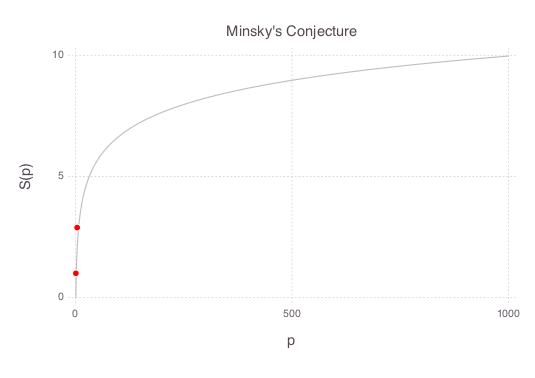

In [4]:
using Gadfly
plot(Guide.title("Minsky's Conjecture"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point,
        Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->log2(p), 1:1000), Geom.line,
        Theme(default_color=colorant"grey75")))

**But that's not the only answer!**

## How to get _a. 637_

Assume speedup is proportional to number of cores.

$$
S(p) \propto p
$$

Cores | Run time (s) | Speedup
--- | --- | ---
1 | 1350 | 1
4 | 530 | 2.5
1000 | **2.12** | **637**

In [13]:
1350/530*1000/4

636.7924528301887

What's wrong with assuming that $S(p) \propto p$?

Why is $S(p) \ne p$? Clearly there's some overhead.
What does overhead mean?

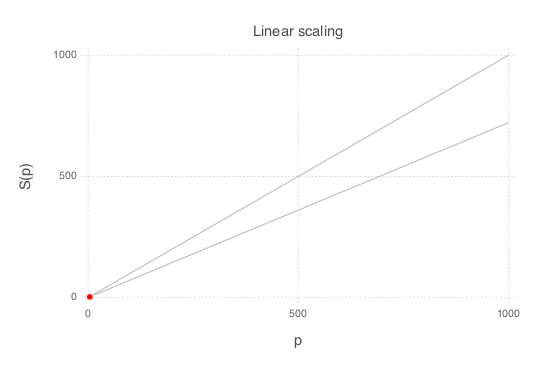

In [5]:
plot(Guide.title("Linear scaling"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->1530/530*p/4, 1:1000), Geom.line,
        Theme(default_color=colorant"grey50")),
    layer(x=1:1000, y=1:1000, Geom.line,
        Theme(default_color=colorant"grey75")),
)

## How to get _e. 5_

Assume the program has two components, one part that can be parallelized perfectly and another part cannot be parallelized at all. Let $x$ be the fraction of the runtime on 1 core taken up by the first part.

On $p$ cores, the first component will take $x/p$ time and the second component will take $1-x$ time. So the total speedup is

$$
S(p) = \frac{1}{1-x + \frac x p}
$$

This formula is known as **Amdahl's Law**.

$1-x$ is sometimes called the **serial fraction** or the **Karp-Flatt metric**. [doi:10.1145/78607.78614](http://dx.doi.org/10.1145/78607.78614)

## A historical note about Amdahl's Law

Although Amdahl is today credited with the idea behind Amdahl's Law, the traditional citation [doi:10.1145/1465482.1465560](https://dx.doi.org/10.1145%2F1465482.1465560) does not contain a quantitative statement of Amdahl's Law. Instead, Amdahl's paper presents only the general idea that parallel speedups can essentially saturate even in the limit of having many processors, because the bottleneck becomes fraction of time spent in the slowest component. Amdahl also presents graphs showing the characteristic sigmoidal shape of Amdahl's Law.

The phrase "Amdahl's Law" appears to have been coined by Jack Worlton in ["Supercomputers: the Philosophy Behind the Machines"](https://books.google.com/books?id=RCUvkY2SFRAC&pg=PA83), _Computerworld 15 (45)_, 1981, pp. In Depth/1-14. Ironically the "formalization" of Amdahl's Law is equivalent to what Worlton termed Ware's Model of Multiprocessors, citing  [doi:10.1109/MSPEC.1972.5218755](http://dx.doi.org/10.1109/MSPEC.1972.5218755). In fact, what Worlton presented as Ware's Law is identical to what we now know as Amdahl's Law. But Ware himself cites W. R. Graham, "The parallel and the pipeline computer", _Datamation_ 1970, pp. 68-71, as the genesis of the quantitative law.

Using Amdahl's Law, the fraction of the program that can be sped up is 

$$
x = \frac{1 - 1/S(p)}{1 - 1/p}
$$

In our example, $x = 0.810$ and the serial fraction is $1-x = 0.190$.

Cores | Run time (s) | Speedup
--- | --- | ---
1 | 1350 | 1
4 | 530 | 2.5
1000 | **258** | **5.2**

In [7]:
x = (1-530/1350)/(1-1/4)

0.8098765432098766

In [8]:
1/(1 - x + x/1000)

5.237430167597766

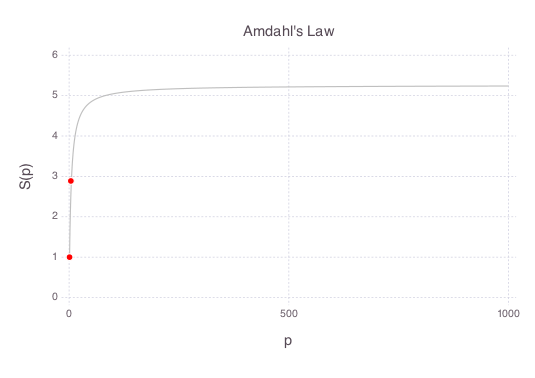

In [9]:
plot(Guide.title("Amdahl's Law"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->1/(1-x+x/p), 1:1000), Geom.line,
        Theme(default_color=colorant"grey75")),
)

## How to get _c. 136_

Parallel programs may have parts that are not perfectly parallelizable; perhaps some parts can only use $i < p$ cores. Let $q_i$ be the fraction of serial work that can be parallelized on $i$ processors. Then the speedup on $p$ processors is

$$
S(p) = \left(\sum_i^p \frac{q_i}{i}\right)^{-1}
$$

[Assuming]((https://en.wikipedia.org/wiki/Principle_of_indifference)) a uniform distribution $q_i = 1/p$, 

$$
S(p) = p \left(\sum_i^p \frac{1}{i}\right)^{-1} = \frac{p}{H_p} 
$$

where $H_p$ is the $p$th [harmonic number](https://en.wikipedia.org/wiki/Harmonic_number). $H_p \sim \ln(p)$ as $p \rightarrow \infty$, so in this limit,

$$
S(p) \sim \frac p {\ln(p)}
$$

Using the [maximum entropy argument](https://en.wikipedia.org/wiki/Principle_of_indifference), the fraction of the program that can be sped up is 

$$
S(p) = \frac p H_p \approx \frac p {\ln(p)}
$$

Cores | Run time (s) | Speedup
--- | --- | ---
1 | 1350 | 1
4 | 530 | 2.5 (law says **1.9**)
1000 | **10** | **136**

References:
- Ruby Bei-Loh Lee, "Performance Bounds for Parallel Processors", PhD thesis, Stanford DSL and Dept. EECS, 1976. [DSL Tech. Report 125](http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA040873)
- [doi:10.1109/TC.1980.1675513](http://dx.doi.org/10.1109/TC.1980.1675513)

In [101]:
p=1000; p/log(p)

144.76482730108395

In [45]:
H = 0.0 #Compute pth harmonic number
for n=1:p
    H += 1/n
end
p/H

LoadError: LoadError: UndefVarError: p not defined
while loading In[45], in expression starting on line 3

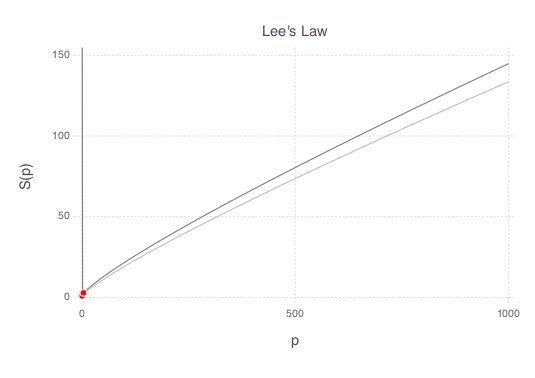

In [13]:
plot(Guide.title("Lee's Law"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->p/sum([1/n for n=1:p]), 1:1000), Geom.line,
        Theme(default_color=colorant"grey75")),
    layer(x=1:1000, y=map(p->p/log(p), 1:1000), Geom.line,
        Theme(default_color=colorant"grey50")),
)

#  Summary of Speedup Folklore

Cores | Run time (s) | Speedup
--- | --- | ---
1 | 1350 | 1
4 | 530 | 2.5
1000 | ? | ?

Speedup on 1000 cores is

a. 637 - linear extrapolation

b. 176

c. 136 - Lee's Law

d. 10 - Minsky's Conjecture

e. 5 - Amdahl's Law

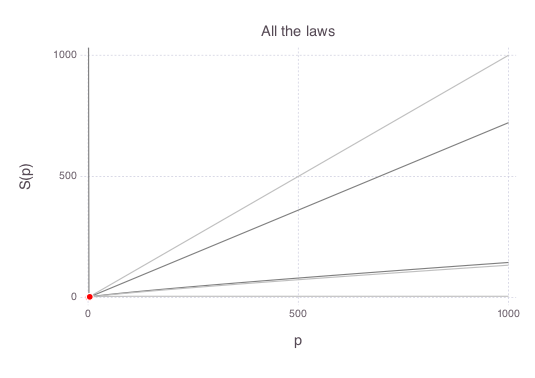

In [15]:
plot(Guide.title("All the laws"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->p/sum([1/n for n=1:p]), 1:1000), Geom.line, Theme(default_color=colorant"grey75")),
    layer(x=1:1000, y=map(p->p/log(p), 1:1000), Geom.line, Theme(default_color=colorant"grey50")),
    layer(x=1:1000, y=map(p->1/(1-x+x/p), 1:1000), Geom.line, Theme(default_color=colorant"grey75")),
    layer(x=1:1000, y=map(p->1530/530*p/4, 1:1000), Geom.line, Theme(default_color=colorant"grey50")),
    layer(x=1:1000, y=1:1000, Geom.line, Theme(default_color=colorant"grey75")),
)

# Exercise 1

(Easy) Derive the linear extrapolation law $S(p) = p$ as a special case of Lee's probabilistic argument. (Hint: All but 1 of the $q_i$s is 0.)

# Exercise 2

(Easy) Derive Amdahl's law as a special case of Lee's probabilistic argument. (Hint: set $q_p = x$.)

# Exercise 3

(Medium; Flynn, 1972) Assume $p$ is a power of 2 and that $q_i$ is 0 unless $i$ is a power of 2, in which case it is some constant $c$. Show that the resulting speedup is

$$
S(p) = \frac{p}{2p - 1}(\log_2 p + 1)
$$

Does this result justify Minsky's Conjecture?

(Note: Flynn missed the factor of +1.)

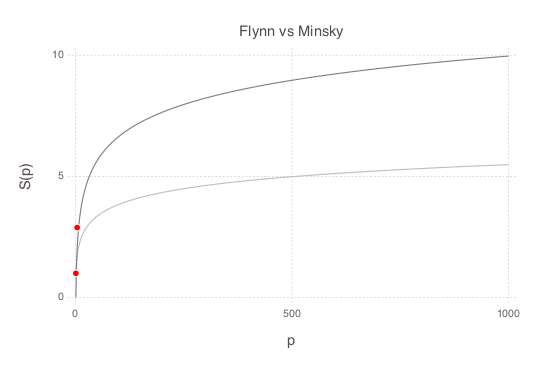

In [18]:
plot(Guide.title("Flynn vs Minsky"),
    Guide.xlabel("p"), Guide.ylabel("S(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->log2(p), 1:1000), Geom.line,
        Theme(default_color=colorant"grey50")),
    layer(x=1:1000, y=map(p->p/(2p-1)*(log2(p)+1), 1:1000), Geom.line,
        Theme(default_color=colorant"grey75"))
)

# Exercise 4

(Hard) Lee's argument is actually a rough estimate from a maximum entropy point of view, because it assumes we don't know anything about the underlying distribution $q_i$ and instead appeals to [Laplace's principle of indifference](https://en.wikipedia.org/wiki/Principle_of_indifference), or what modern Bayesians would call an [uninformative prior](https://en.wikipedia.org/wiki/Prior_probability#Uninformative_priors). We can do better by using the observed speedup to construct a maximum entropy distribution for the $q_i$s. Extrapolate from this distribution to estimate the speedup in our example to be _b. 176_.

# Strong vs. weak scaling

The Amdahl-type arguments we have just seen are examples of **strong scaling**, where the workload is fixed and the number of processors $p$ increases.

Gustafson and Barsis argued that because in practice, parallel computers can solve bigger problems, **weak scaling** is more important, where the workload _per processor_ is constant. [doi:10.1145/42411.42415](http://dx.doi.org/10.1145/42411.42415)

Denote again $1-x$ as the serial fraction and $x$ as the fraction run in parallel. On a serial computer, the part that would have run in parallel would take $px$ time instead of $x$. Weak scaling considers the _scaled speedup_

$$
S'(p) = 1-x + px = (p-1)x + 1
$$

This equation is also known as *Gustafson's Law*.

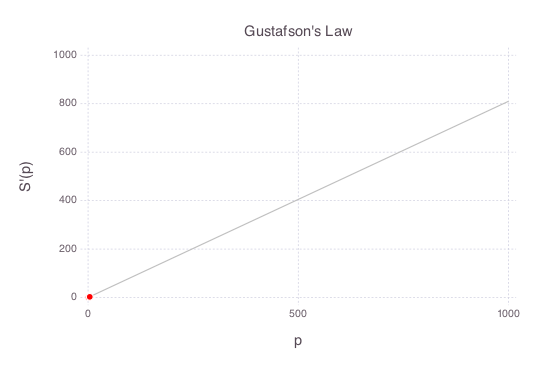

In [19]:
plot(Guide.title("Gustafson's Law"),
    Guide.xlabel("p"), Guide.ylabel("S'(p)"), 
    layer(x=[1,4], y=[1, 1530/530], Geom.point, Theme(default_color=colorant"red")),
    layer(x=1:1000, y=map(p->(p-1)*x+1, 1:1000), Geom.line,
        Theme(default_color=colorant"grey75"))
)

# Scaling intermediate between strong and weak

Sun and Ni consider cases where the workload doesn't grow as $p$, but rather as yet another scaling function $G(p)$. The use case is to discuss **memory-bound** scaling, where memory use is the bottleneck as opposed to workload (strong scaling limit) or time (weak scaling limit).

Xian-He Sun and Lionel M Ni, ["Another view on parallel speedup"](http://dl.acm.org/citation.cfm?id=110450), _Proceedings of the 1990 ACM/IEEE conference on Supercomputing '90_, IEEE Computer Society Press: Los Alamitos, CA, 1990, pp. 324-333.

# Limitations of scaling analysis

Scaling analyses consider only how to divide up resources like CPU time and memory.

Other factors that play into real world speedup:

- communication costs, which depend on the algorithm

- non-uniform memory access (NUMA), especially if the problem size per process crosses a boundary (e.g. main RAM -> L3 cache)

- dependency ordering of tasks (critical paths, bottlenecks, load imbalance...)

- other changes in algorithmic behavior as work size changes (speculative loss, ...)

In [21]:
#From Julia 0.4 onward, distributed arrays live in their own package
if VERSION ≥ v"0.4.0"
    #Pkg.add("DistributedArrays")
    using DistributedArrays
end

import Base: +
function +{T,N,TA}(A::DArray{T,N,TA}, B::DArray{T,N,TA})
    @assert A.dims == B.dims
    @assert A.pmap == B.pmap
    @assert A.indexes == B.indexes
    @assert A.cuts == B.cuts
    chunks = RemoteRef[@spawnat p localpart(A)+localpart(B) for p in A.pmap]
    DArray{T,N,TA}(A.dims, chunks, A.pmap, A.indexes, A.cuts)
end

+ (generic function with 265 methods)

In [22]:
function benchmark(n)
    @sync begin
        B = drandn(n)
        C = drandn(n)
    end
    tpar = @elapsed @sync A=B+C
    E = randn(n)
    F = randn(n)
    tser = @elapsed D = E + F
    tser/tpar
end

benchmark (generic function with 1 method)

In [43]:
#If you don't have this package installed, run
#Pkg.add("ProgressMeter")
using ProgressMeter

#Kill any workers already spawned
rmprocs(procs()[2:end])

#Run benchmark
problemsizes = [2*10^6, 5*10^6, 10^7, 2*10^7, 5*10^7]
speedups = zeros(CPU_CORES, length(problemsizes))
@showprogress for i=1:CPU_CORES
    addprocs(1)
    @everywhere using DistributedArrays #Make sure DArrays are defined everywhere
    speedups[i, :] = map(benchmark, problemsizes)
end
speedups

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


4x5 Array{Float64,2}:
 0.00357836  0.750487  0.96142  1.22584   5.23354
 2.24309     2.1679    2.17906  1.41028  19.7552 
 4.11046     1.8061    2.3179   1.38948   2.68632
 0.573506    2.38538   3.12633  9.75439   3.15824

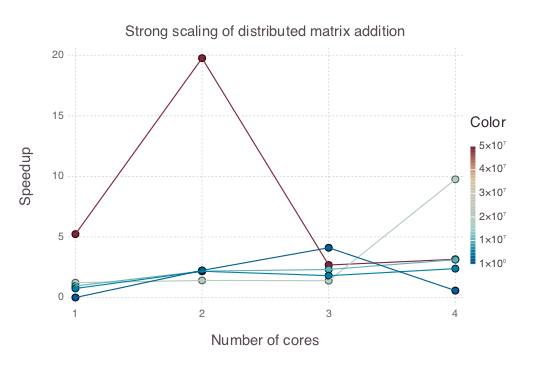

In [44]:
plot(Guide.xlabel("Number of cores"), Guide.ylabel("Speedup"),
    Guide.title("Strong scaling of distributed matrix addition"),
    Coord.Cartesian(xmin=1),
    [layer(x=1:CPU_CORES, y=speedups[:,i], color=fill(problemsizes[i],CPU_CORES),
        Geom.line, Geom.point)
        for i=1:length(problemsizes)]...)

# Exercise 5

If you run this code a few times, you'll notice that the numbers are not always stable. How can this code be improved?

# Exercise 6

Modify this code to plot weak scaling.

# Exercise 7

Plot strong scaling and weak scaling curves for your own parallel program.